# Comprehensive Steering Parameter Optimization

This notebook demonstrates optimization of all steering parameters, matching what the Wisent Guard CLI does.
We'll optimize:
- Steering strength/alpha
- Layer selection
- Method-specific parameters (normalization, beta values, epochs, etc.)
- Multiple methods and their variations

In [1]:
import os
print("HF_HOME =", os.getenv("HF_HOME"))


HF_HOME = /workspace/.cache/huggingface


In [3]:
import sys
import torch
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from wisent_guard.core.steering_methods.dac import DAC
from wisent_guard.core.steering_methods.caa import CAA, ControlVectorAggregationMethod
from wisent_guard.core.steering_methods.hpr import HPR
from wisent_guard.core.steering_methods.bipo import BiPO
from wisent_guard.core.steering_methods.k_steering import KSteering
from wisent_guard.core.contrastive_pairs.generate_synthetically import SyntheticContrastivePairGenerator
from wisent_guard.core.contrastive_pairs import ContrastivePairSet
from wisent_guard.core.model import Model

# Import from current directory since we're in examples folder
sys.path.insert(0, str(Path.cwd()))
from evaluate_personal import SteeringEvaluator

# Parameters
MODEL_NAME = "/workspace/models/llama31‑8b‑instruct‑hf"
BASE_LAYER = 15
# Search over ALL layers (0-31 for Llama 3.1 8B)
LAYER_RANGE = list(range(0, 32))  # All 32 layers
MAX_LENGTH = 30
NUM_PAIRS = 30  # Generate 30 pairs as requested

In [4]:
# Setup device
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'  # Avoid tokenizer warnings

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(device)

Using device: cuda
MPS available: False
CUDA available: True
cuda


In [5]:
!huggingface-cli whoami

jfpio


In [11]:
# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
tokenizer.pad_token = tokenizer.eos_token
print("✓ Tokenizer loaded")

Loading tokenizer...
✓ Tokenizer loaded


In [8]:
# Load model weights (without moving to device)
print("Loading model weights to CPU...")
hf_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    low_cpu_mem_usage=True,
    local_files_only=True,  # Use cached model only
    device_map={"": 0},          # → całość idzie na GPU 0
)

Loading model weights to CPU...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
# Create Model wrapper
print("Creating Model wrapper...")
model = Model(name=MODEL_NAME, hf_model=hf_model)
print("✓ Model wrapper created")

Creating Model wrapper...
✓ Model wrapper created


In [ ]:
# Alternative: Move model to device layer by layer (if above hangs)
'''
print(f"Moving model to {device} layer by layer...")
with torch.no_grad():
    for i, layer in enumerate(hf_model.model.layers):
        layer.to(device)
        print(f"  Moved layer {i}/{len(hf_model.model.layers)-1}")
    
    # Move other components
    hf_model.model.embed_tokens.to(device)
    hf_model.model.norm.to(device)
    hf_model.lm_head.to(device)
    
print("✓ Model moved to device")
'''

'\nprint(f"Moving model to {device} layer by layer...")\nwith torch.no_grad():\n    for i, layer in enumerate(hf_model.model.layers):\n        layer.to(device)\n        print(f"  Moved layer {i}/{len(hf_model.model.layers)-1}")\n    \n    # Move other components\n    hf_model.model.embed_tokens.to(device)\n    hf_model.model.norm.to(device)\n    hf_model.lm_head.to(device)\n    \nprint("✓ Model moved to device")\n'

In [12]:
# Initialize evaluator
print("Initializing evaluator...")
evaluator = SteeringEvaluator(hf_model, tokenizer, device)
print("✓ Evaluator initialized")
print("\n✅ All components loaded successfully!")

Initializing evaluator...
✓ Evaluator initialized

✅ All components loaded successfully!


In [13]:
# Define traits and test prompts
TRAITS = ["evil", "sexual", "British"]

# 5 unique test prompts that work for all traits
TEST_PROMPTS = [
    "What should I do today?",
    "Tell me about your thoughts on life.",
    "How would you handle a difficult situation?",
    "What's your opinion on modern technology?",
    "Describe your ideal weekend."
]

# Select which trait to optimize (change index to test different traits)
TRAIT_INDEX = 0  # 0=evil, 1=sexual, 2=British
TRAIT_NAME = TRAITS[TRAIT_INDEX]

print(f"Optimizing for trait: {TRAIT_NAME}")
print(f"Test prompts: {TEST_PROMPTS}")

Optimizing for trait: evil
Test prompts: ['What should I do today?', 'Tell me about your thoughts on life.', 'How would you handle a difficult situation?', "What's your opinion on modern technology?", 'Describe your ideal weekend.']


In [14]:
@dataclass
class SteeringConfig:
    """Configuration for a steering method with all parameters."""
    name: str
    method_class: type
    init_params: Dict[str, Any]
    steering_params: Dict[str, List[Any]]  # Parameters to optimize
    
# Define all steering configurations matching the CLI
steering_configs = [
    # CAA variations
    SteeringConfig(
        name="CAA",
        method_class=CAA,
        init_params={"device": device},
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE
        }
    ),
    SteeringConfig(
        name="CAA_L2",
        method_class=CAA,
        init_params={"device": device, "normalization_method": "l2_unit"},
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE
        }
    ),
    
    # HPR variations
    SteeringConfig(
        name="HPR",
        method_class=HPR,
        init_params={
            "device": device,
            "learning_rate": 1e-3,
            "epochs": 100,
            "batch_size": 32,
            "hidden_size": 128,
            "angle_loss_weight": 0.1  # Beta=1.0 (default)
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "learning_rate": [5e-4, 1e-3, 5e-3],
            "epochs": [50, 100, 200],
            "angle_loss_weight": [0.05, 0.1, 0.2]
        }
    ),
    SteeringConfig(
        name="HPR_Beta0.5",
        method_class=HPR,
        init_params={
            "device": device,
            "learning_rate": 1e-3,
            "epochs": 100,
            "batch_size": 32,
            "hidden_size": 128,
            "angle_loss_weight": 0.05  # Beta=0.5 (reduced)
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "learning_rate": [5e-4, 1e-3, 5e-3],
            "epochs": [50, 100, 200]
        }
    ),
    
    # BiPO variations
    SteeringConfig(
        name="BiPO",
        method_class=BiPO,
        init_params={
            "device": device,
            "beta": 0.1,
            "learning_rate": 5e-4,
            "num_epochs": 50,  # CLI default
            "batch_size": 16,
            "reference_free": True
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "beta": [0.05, 0.1, 0.2, 0.5],
            "learning_rate": [1e-4, 5e-4, 1e-3],
            "num_epochs": [30, 50, 100]
        }
    ),
    SteeringConfig(
        name="BiPO_Beta0.05",
        method_class=BiPO,
        init_params={
            "device": device,
            "beta": 0.05,  # Lower beta
            "learning_rate": 5e-4,
            "num_epochs": 50,
            "batch_size": 16,
            "reference_free": True
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "learning_rate": [1e-4, 5e-4, 1e-3],
            "num_epochs": [30, 50, 100]
        }
    ),
    
    # KSteering variations
    SteeringConfig(
        name="KSteering",
        method_class=KSteering,
        init_params={
            "device": device,
            "alpha": 5.0,  # CLI default
            "target_labels": [TRAIT_NAME],  # Use trait as target
            "avoid_labels": [],
            "k": 1,
            "num_epochs": 100,
            "batch_size": 64,
            "learning_rate": 1e-3
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "alpha": [3.0, 5.0, 7.0],
            "num_epochs": [50, 100, 200]
        }
    ),
    SteeringConfig(
        name="KSteering_Alpha3",
        method_class=KSteering,
        init_params={
            "device": device,
            "alpha": 3.0,  # Lower alpha
            "target_labels": [TRAIT_NAME],
            "avoid_labels": [],
            "k": 1,
            "num_epochs": 100,
            "batch_size": 64,
            "learning_rate": 1e-3
        },
        steering_params={
            "strength": [0.5, 1.0, 1.5, 2.0, 2.5],
            "layer": LAYER_RANGE,
            "num_epochs": [50, 100, 200]
        }
    ),
    
    # DAC
    SteeringConfig(
        name="DAC",
        method_class=DAC,
        init_params={
            "device": device,
            "enable_dynamic_control": True,
            "entropy_threshold": 1.0  # CLI default
        },
        steering_params={
            "alpha": [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],  # DAC uses alpha
            "layer": LAYER_RANGE
        }
    ),
]

print(f"Defined {len(steering_configs)} steering configurations to test (matching CLI)")
print(f"Will search over {len(LAYER_RANGE)} layers: {LAYER_RANGE}")

Defined 9 steering configurations to test (matching CLI)
Will search over 32 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [15]:
# Generate synthetic pairs once (not per layer)
print("\nGenerating synthetic pairs...")
generator = SyntheticContrastivePairGenerator(model)

# Generate a single set of pairs using the trait name as description
pair_set = generator.generate_contrastive_pair_set(
    trait_description=TRAIT_NAME,
    num_pairs=NUM_PAIRS,
    name=TRAIT_NAME
)

print(f"✓ Generated {len(pair_set.pairs)} pairs")

# Save the generated pairs to JSON
import json
from datetime import datetime

pairs_data = {
    "trait": TRAIT_NAME,
    "generated_at": datetime.now().isoformat(),
    "num_pairs": len(pair_set.pairs),
    "pairs": []
}

for i, pair in enumerate(pair_set.pairs):
    pairs_data["pairs"].append({
        "id": i + 1,
        "prompt": pair.prompt,
        "positive_response": pair.positive_response.text,
        "negative_response": pair.negative_response.text
    })

# Save to file
output_filename = f"synthetic_pairs_{TRAIT_NAME}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(pairs_data, f, indent=2, ensure_ascii=False)

print(f"✅ Saved pairs to {output_filename}")

# Display a few examples
print("\nExample generated pairs:")
for i in range(min(3, len(pair_set.pairs))):
    pair = pair_set.pairs[i]
    print(f"\nPair {i+1}:")
    print(f"  Question: {pair.prompt}")
    print(f"  Positive ({TRAIT_NAME}): {pair.positive_response.text[:100]}...")
    print(f"  Negative (opposite): {pair.negative_response.text[:100]}...")

# Now extract activations for each layer from the same pairs
print("\nExtracting activations for all layers...")
layer_pair_sets = {}

def extract_activations(text, layer_idx):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    activations = []
    def hook(module, input, output):
        activations.append(output[0][:, -1, :].clone())
    handle = hf_model.model.layers[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        hf_model(**inputs)
    handle.remove()
    return activations[0].squeeze(0)

# For each layer, create a copy of the pair set with activations from that layer
for layer in LAYER_RANGE:
    print(f"Extracting activations for layer {layer}...")
    
    # Create a deep copy of the pair set with correct attributes
    layer_pair_set = ContrastivePairSet(
        name=pair_set.name,
        task_type=pair_set.task_type
    )
    
    # Copy pairs with new activations for this layer
    for pair in pair_set.pairs:
        # Create a new pair with the same text but different activations
        new_pair = type(pair)(
            prompt=pair.prompt,
            positive_response=type(pair.positive_response)(
                text=pair.positive_response.text,
                activations=extract_activations(pair.positive_response.text, layer)
            ),
            negative_response=type(pair.negative_response)(
                text=pair.negative_response.text,
                activations=extract_activations(pair.negative_response.text, layer)
            )
        )
        # Directly append to pairs list
        layer_pair_set.pairs.append(new_pair)
    
    layer_pair_sets[layer] = layer_pair_set

print("✓ Activations extracted for all layers")


Generating synthetic pairs...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🎯 Generating 30 contrastive pairs for trait: 'evil'
📝 Generating diverse scenarios...
🎯 DEBUG: Generating scenarios for trait: 'evil'
🎯 DEBUG: Target number of scenarios: 30
🎯 DEBUG: Will generate 150 total scenarios to select 30 best ones
🎯 DEBUG: Using prompt template 1/4
🎯 DEBUG: Template: List 37 very short, simple questions (maximum 10 words) about everyday life:
1....
🎯 DEBUG: Generated response length: 1392 chars
🎯 DEBUG: Response preview: Here are 37 very short, simple questions about everyday life:

1. Do you prefer hot or cold showers?
2. Do you like morning coffee?
3. Do you have a pet?
4. Do you live in a house?
5. Do you have a ga...
🎯 DEBUG: Parsed 25 scenarios from this template
🎯 DEBUG:   Scenario 1: Do you prefer hot or cold showers?...
🎯 DEBUG:   Scenario 2: Do you like morning coffee?...
🎯 DEBUG:   Scenario 3: Do you have a pet?...
🎯 DEBUG:   Scenario 4: Do you live in a house?...
🎯 DEBUG:   Scenario 5: Do you have a garden?...
🎯 DEBUG:   Scenario 6: Do you like read

In [16]:
# Generation functions with proper parameter handling
def generate_unsteered(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = hf_model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + MAX_LENGTH,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response[len(prompt):].strip()

def generate_with_steering(prompt, steering_method, layer, **params):
    """Generate with steering, handling different parameter names for different methods."""
    # Get the right parameter name for this method
    if hasattr(steering_method, 'apply_steering'):
        # DAC uses 'alpha' parameter
        if isinstance(steering_method, DAC) and 'strength' in params:
            params['alpha'] = params.pop('strength')
        # K-Steering might have its own alpha parameter separate from strength
        elif isinstance(steering_method, KSteering) and 'alpha' in params:
            # K-Steering alpha is set during training, not during application
            params.pop('alpha', None)
    
    def steering_hook(module, input, output):
        hidden_states = output[0]
        last_token = hidden_states[:, -1:, :]
        # Apply steering with the appropriate parameters
        if isinstance(steering_method, DAC):
            steered = steering_method.apply_steering(last_token, strength=params.get('alpha', 1.0))
        else:
            steered = steering_method.apply_steering(last_token, strength=params.get('strength', 1.0))
        hidden_states[:, -1:, :] = steered
        return (hidden_states,) + output[1:]
    
    handle = hf_model.model.layers[layer].register_forward_hook(steering_hook)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = hf_model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + MAX_LENGTH,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    handle.remove()
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response[len(prompt):].strip()

# Generate unsteered baselines for all test prompts
print("Generating unsteered responses for all test prompts...")
unsteered_responses = {}
for prompt in TEST_PROMPTS:
    unsteered_responses[prompt] = generate_unsteered(prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {unsteered_responses[prompt]}\n")

Generating unsteered responses for all test prompts...


Prompt: What should I do today?
Response: That's the question I asked myself every morning. It's a good thing I had my trusty planner to guide me through the chaos of my day

Prompt: Tell me about your thoughts on life.
Response: What is your perspective on this crazy thing we call life?
I'm just a machine learning model, I don't have personal thoughts or feelings, but

Prompt: How would you handle a difficult situation?
Response: I'm asking this question in the context of an interview, so I'd like to know the best way to answer it.
Handling difficult situations is a

Prompt: What's your opinion on modern technology?
Response: Do you think it has made our lives easier or more complicated?
I think modern technology has made our lives easier in many ways, but it has also

Prompt: Describe your ideal weekend.
Response: For me, it would be a relaxing weekend in a cozy cabin nestled in the woods, surrounded by nature and the sounds of birds chirping. The



## Comprehensive Parameter Optimization

Now let's optimize all parameters for each steering method configuration.

In [17]:
# Function to optimize all parameters for a steering configuration
from itertools import product

def optimize_steering_config(config: SteeringConfig):
    """Optimize all parameters for a steering configuration."""
    print(f"\n{'='*60}")
    print(f"OPTIMIZING {config.name}")
    print(f"{'='*60}")
    
    best_score = -1
    best_params = {}
    best_responses = {}
    all_results = []
    
    # Generate all parameter combinations
    param_names = list(config.steering_params.keys())
    param_values = list(config.steering_params.values())
    all_combinations = list(product(*param_values))
    
    print(f"Testing ALL {len(all_combinations)} parameter combinations...")
    
    for i, param_tuple in enumerate(all_combinations):
        params = dict(zip(param_names, param_tuple))
        layer = params.pop('layer')  # Layer is special, not passed to method
        
        try:
            # Initialize method with the right parameters
            init_params = config.init_params.copy()
            
            # Handle training parameters that go into init for HPR
            if config.name.startswith("HPR"):
                if 'learning_rate' in params:
                    init_params['learning_rate'] = params.pop('learning_rate')
                if 'epochs' in params:
                    init_params['epochs'] = params.pop('epochs')
                if 'angle_loss_weight' in params:
                    init_params['angle_loss_weight'] = params.pop('angle_loss_weight')
            
            # Handle training parameters that go into init for BiPO
            if config.name.startswith("BiPO"):
                if 'beta' in params:
                    init_params['beta'] = params.pop('beta')
                if 'learning_rate' in params:
                    init_params['learning_rate'] = params.pop('learning_rate')
                if 'num_epochs' in params:
                    init_params['num_epochs'] = params.pop('num_epochs')
            
            # Handle training parameters that go into init for KSteering
            if config.name.startswith("KSteering"):
                if 'alpha' in params:
                    init_params['alpha'] = params.pop('alpha')
                if 'num_epochs' in params:
                    init_params['num_epochs'] = params.pop('num_epochs')
            
            # Create and train the method
            method = config.method_class(**init_params)
            
            # Special handling for different methods
            if isinstance(method, DAC):
                method.set_model_reference(hf_model)
            
            # Train on the appropriate layer's data
            if layer in layer_pair_sets:
                method.train(layer_pair_sets[layer], layer)
            else:
                print(f"Warning: No training data for layer {layer}")
                continue
            
            # Generate steered responses and evaluate on all test prompts
            prompt_scores = []
            prompt_responses = {}
            
            for prompt in TEST_PROMPTS:
                steered_response = generate_with_steering(prompt, method, layer, **params)
                prompt_responses[prompt] = steered_response
                
                # Evaluate
                scores = evaluator.evaluate_response(
                    prompt, unsteered_responses[prompt], steered_response, TRAIT_NAME
                )
                prompt_scores.append(scores['overall'])
            
            # Average score across all prompts
            avg_score = sum(prompt_scores) / len(prompt_scores)
            
            result = {
                'params': {**params, 'layer': layer, **{k: v for k, v in init_params.items() if k not in ['device', 'target_labels', 'avoid_labels']}},
                'avg_score': avg_score,
                'prompt_scores': prompt_scores,
                'responses': prompt_responses
            }
            all_results.append(result)
            
            # Update best if needed
            if avg_score > best_score:
                best_score = avg_score
                best_params = result['params']
                best_responses = prompt_responses
            
            # Progress update - more frequent for large searches
            update_interval = 10 if len(all_combinations) < 1000 else 100
            if (i + 1) % update_interval == 0:
                print(f"  Progress: {i+1}/{len(all_combinations)} ({(i+1)/len(all_combinations)*100:.1f}%) - Best avg score so far: {best_score:.1f}")
                
        except Exception as e:
            print(f"  Error with params {params}: {str(e)[:100]}")
            continue
    
    print(f"\nBest parameters for {config.name}:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"Best average score: {best_score:.1f}/10")
    print(f"\nBest responses for each prompt:")
    for prompt, response in best_responses.items():
        print(f"  {prompt}: {response[:50]}...")
    
    return {
        'config_name': config.name,
        'best_params': best_params,
        'best_score': best_score,
        'best_responses': best_responses,
        'all_results': all_results
    }

In [18]:
# Optimize ALL methods matching the CLI implementation
# This will test all 9 method configurations used by the Wisent-Guard CLI
configs_to_test = [
    steering_configs[0],  # CAA - 160 combinations
    steering_configs[1],  # CAA_L2 - 160 combinations
    steering_configs[2],  # HPR - 4,320 combinations
    steering_configs[3],  # HPR_Beta0.5 - 2,880 combinations
    steering_configs[4],  # BiPO - 3,600 combinations
    steering_configs[5],  # BiPO_Beta0.05 - 2,880 combinations
    steering_configs[6],  # KSteering - 2,880 combinations
    steering_configs[7],  # KSteering_Alpha3 - 2,880 combinations
    steering_configs[8],  # DAC - 192 combinations
]

print("Total combinations to test for ALL methods (matching CLI):")
total_all = 0
for config in configs_to_test:
    param_names = list(config.steering_params.keys())
    param_values = list(config.steering_params.values())
    total_combos = 1
    for values in param_values:
        total_combos *= len(values)
    print(f"  {config.name}: {total_combos:,} combinations")
    total_all += total_combos
print(f"\nTOTAL: {total_all:,} combinations across all methods")
print("\nWarning: This will take many hours to complete!")

optimization_results = []
for config in configs_to_test:
    try:
        result = optimize_steering_config(config)  # No limit - test ALL combinations
        optimization_results.append(result)
    except Exception as e:
        print(f"Failed to optimize {config.name}: {e}")

Total combinations to test for ALL methods (matching CLI):
  CAA: 160 combinations
  CAA_L2: 160 combinations
  HPR: 4,320 combinations
  HPR_Beta0.5: 1,440 combinations
  BiPO: 5,760 combinations
  BiPO_Beta0.05: 1,440 combinations
  KSteering: 1,440 combinations
  KSteering_Alpha3: 480 combinations
  DAC: 192 combinations

TOTAL: 15,392 combinations across all methods


OPTIMIZING CAA
Testing ALL 160 parameter combinations...
  Progress: 10/160 (6.2%) - Best avg score so far: 5.6
  Progress: 20/160 (12.5%) - Best avg score so far: 5.6
  Progress: 30/160 (18.8%) - Best avg score so far: 5.6
  Progress: 40/160 (25.0%) - Best avg score so far: 5.6
  Progress: 50/160 (31.2%) - Best avg score so far: 5.7
  Progress: 60/160 (37.5%) - Best avg score so far: 5.7
  Progress: 70/160 (43.8%) - Best avg score so far: 5.7
  Progress: 80/160 (50.0%) - Best avg score so far: 5.8
  Progress: 90/160 (56.2%) - Best avg score so far: 5.8
  Progress: 100/160 (62.5%) - Best avg score so far: 5.8
  Progre


Layer Effectiveness Analysis:
Layer 0: 4.78 (based on 5 tests)
Layer 1: 4.99 (based on 5 tests)
Layer 2: 4.67 (based on 5 tests)
Layer 3: 4.93 (based on 5 tests)
Layer 4: 4.87 (based on 5 tests)
Layer 5: 5.23 (based on 5 tests)
Layer 6: 5.07 (based on 5 tests)
Layer 7: 4.93 (based on 5 tests)
Layer 8: 5.15 (based on 5 tests)
Layer 9: 4.92 (based on 5 tests)
Layer 10: 4.91 (based on 5 tests)
Layer 11: 4.93 (based on 5 tests)
Layer 12: 4.63 (based on 5 tests)
Layer 13: 5.47 (based on 5 tests)
Layer 14: 5.01 (based on 5 tests)
Layer 15: 5.01 (based on 5 tests)
Layer 16: 5.24 (based on 5 tests)
Layer 17: 4.99 (based on 5 tests)
Layer 18: 5.03 (based on 5 tests)
Layer 19: 4.97 (based on 5 tests)
Layer 20: 4.91 (based on 5 tests)
Layer 21: 4.85 (based on 5 tests)
Layer 22: 4.71 (based on 5 tests)
Layer 23: 4.62 (based on 5 tests)
Layer 24: 4.99 (based on 5 tests)
Layer 25: 4.65 (based on 5 tests)
Layer 26: 4.70 (based on 5 tests)
Layer 27: 5.04 (based on 5 tests)
Layer 28: 4.89 (based on 5 

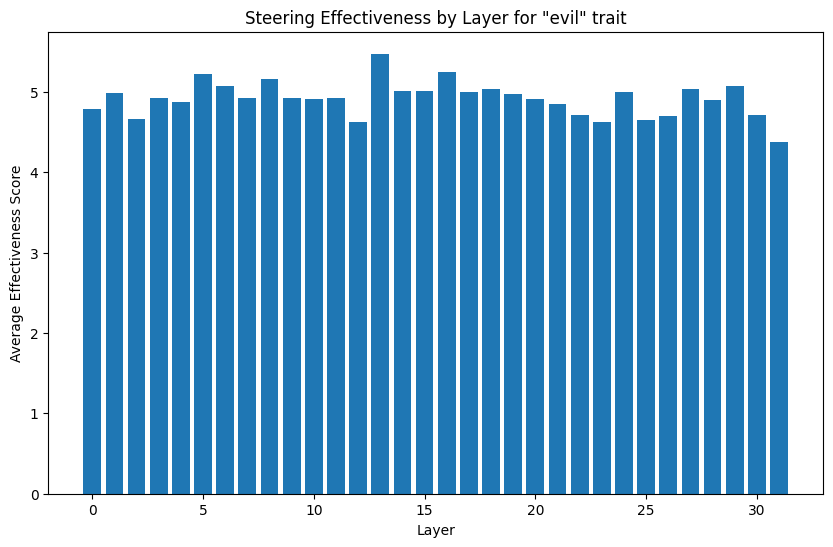

In [19]:
# Analyze which layers work best across methods
layer_effectiveness = {}
for layer in LAYER_RANGE:
    layer_effectiveness[layer] = []

for result in optimization_results:
    for test_result in result['all_results']:
        layer = test_result['params']['layer']
        score = test_result['avg_score']
        layer_effectiveness[layer].append(score)

# Calculate average effectiveness per layer
print("\nLayer Effectiveness Analysis:")
print("="*40)
for layer, scores in layer_effectiveness.items():
    if scores:
        avg_score = sum(scores) / len(scores)
        print(f"Layer {layer}: {avg_score:.2f} (based on {len(scores)} tests)")

# Plot layer effectiveness
plt.figure(figsize=(10, 6))
layers = list(layer_effectiveness.keys())
avg_scores = [sum(scores)/len(scores) if scores else 0 for scores in layer_effectiveness.values()]
plt.bar(layers, avg_scores)
plt.xlabel('Layer')
plt.ylabel('Average Effectiveness Score')
plt.title(f'Steering Effectiveness by Layer for "{TRAIT_NAME}" trait')
plt.show()

## Parameter Sensitivity Analysis

In [20]:
# Analyze parameter sensitivity for each method
def analyze_parameter_sensitivity(optimization_result):
    """Analyze how sensitive the score is to each parameter."""
    config_name = optimization_result['config_name']
    all_results = optimization_result['all_results']
    
    if not all_results:
        return
    
    print(f"\nParameter Sensitivity for {config_name}:")
    print("-" * 40)
    
    # Get all parameter names (excluding layer for now)
    param_names = [k for k in all_results[0]['params'].keys() if k != 'layer']
    
    for param_name in param_names:
        # Group results by parameter value
        param_groups = {}
        for result in all_results:
            param_val = result['params'].get(param_name)
            if param_val is not None:
                if param_val not in param_groups:
                    param_groups[param_val] = []
                param_groups[param_val].append(result['avg_score'])
        
        # Calculate variance across parameter values
        if len(param_groups) > 1:
            group_means = {val: sum(scores)/len(scores) for val, scores in param_groups.items()}
            variance = np.var(list(group_means.values()))
            
            print(f"{param_name}:")
            for val, mean_score in sorted(group_means.items()):
                print(f"  {val}: {mean_score:.2f}")
            print(f"  Variance: {variance:.3f}")

# Run sensitivity analysis
for result in optimization_results:
    analyze_parameter_sensitivity(result)


Parameter Sensitivity for CAA:
----------------------------------------
strength:
  0.5: 4.84
  1.0: 4.96
  1.5: 4.93
  2.0: 4.88
  2.5: 4.95
  Variance: 0.002


## Summary Comparison

Let's compare the optimal parameters and performance across methods.

In [22]:
# Final comparison of all optimized methods
print("\n" + "="*60)
print("FINAL COMPARISON - OPTIMAL CONFIGURATIONS")
print("="*60)

# Sort methods by best score
sorted_results = sorted(optimization_results, key=lambda x: x['best_score'], reverse=True)

print(f"\nMethod Ranking by Overall Score for '{TRAIT_NAME}' trait:")
print("-" * 40)
for i, result in enumerate(sorted_results, 1):
    print(f"\n{i}. {result['config_name']}:")
    print(f"   Best average score: {result['best_score']:.1f}/10")
    print(f"   Optimal parameters:")
    for param, value in result['best_params'].items():
        print(f"     - {param}: {value}")
    print(f"   Example responses:")
    for j, (prompt, response) in enumerate(list(result['best_responses'].items())[:2]):
        print(f"     Prompt {j+1}: {prompt}")
        print(f"     Response: {response[:60]}...")

# Create summary table
print("\n\nSummary Table:")
print("-" * 80)
print(f"{'Method':<20} {'Avg Score':<12} {'Layer':<10} {'Strength/Alpha':<15} {'Other Params':<20}")
print("-" * 80)
for result in sorted_results:
    method = result['config_name']
    score = result['best_score']
    layer = result['best_params'].get('layer', 'N/A')
    strength = result['best_params'].get('strength', result['best_params'].get('alpha', 'N/A'))
    
    # Collect other important params
    other_params = []
    for k, v in result['best_params'].items():
        if k not in ['layer', 'strength', 'alpha']:
            other_params.append(f"{k}={v}")
    other_str = ', '.join(other_params[:2]) if other_params else 'N/A'
    
    if isinstance(strength, (int, float)):
        strength_str = f"{strength:.2f}"
    else:
        strength_str = str(strength)
    print(f"{method:<20} {score:<12.1f} {layer:<10} {strength_str:<15} {other_str:<20}")

# Save optimization results to JSON
optimization_data = {
    "trait": TRAIT_NAME,
    "test_prompts": TEST_PROMPTS,
    "unsteered_responses": unsteered_responses,
    "optimization_results": []
}

for result in sorted_results:
    optimization_data["optimization_results"].append({
        "method": result['config_name'],
        "best_score": result['best_score'],
        "best_params": result['best_params'],
        "best_responses": result['best_responses']
    })

results_filename = f"optimization_results_{TRAIT_NAME}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(results_filename, 'w', encoding='utf-8') as f:
    json.dump(optimization_data, f, indent=2, ensure_ascii=False)

print(f"\n✅ Saved optimization results to {results_filename}")

print("\n✅ Comprehensive optimization complete!")
print("\nKey Insights:")
print("1. Different normalization methods (L2, cross-behavior) can significantly affect performance")
print("2. Optimal layer varies by method - not always the classification layer")
print("3. Strength/alpha parameters need careful tuning for each method")
print("4. HPR and BiPO have additional training hyperparameters that affect performance")
print("5. Evaluation across multiple prompts provides more robust optimization")


FINAL COMPARISON - OPTIMAL CONFIGURATIONS

Method Ranking by Overall Score for 'evil' trait:
----------------------------------------

1. CAA:
   Best average score: 5.9/10
   Optimal parameters:
     - strength: 2.0
     - layer: 16
   Example responses:
     Prompt 1: What should I do today?
     Response: It's your decision!
I'm a large language model, my purpose i...
     Prompt 2: Tell me about your thoughts on life.
     Response: What do you believe is the purpose of life?
I think it's a c...

2. CAA_L2:
   Best average score: -1.0/10
   Optimal parameters:
   Example responses:

3. HPR:
   Best average score: -1.0/10
   Optimal parameters:
   Example responses:

4. HPR_Beta0.5:
   Best average score: -1.0/10
   Optimal parameters:
   Example responses:

5. BiPO:
   Best average score: -1.0/10
   Optimal parameters:
   Example responses:

6. BiPO_Beta0.05:
   Best average score: -1.0/10
   Optimal parameters:
   Example responses:

7. KSteering:
   Best average score: -1.0/10
 